# CAB420, Classification, Example 1: Classification Three Ways
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we'll explore:
* Three types of classification models, SVMs, K-Nearest Neighbours, and Random Forests.
* Introduce confusion matricies, which are a good way to visualise performance.
* Look at how we select hyper-parameters, and ways to help automate this process

## Too Long; Didn't Read
* SVMs fit a plane to separate our two classes. This requires data to be "linearly separable", which may not always be the case. Kernel functions are our friend in such situations, though care needs to be taken to not overfit. Kernels add complexity to the system, and thus using very complex kernels can have a detrimental impact on validation and testing data.
* SVMs can have the costs of errors altered to better deal with imbalance data. Costs are relate to the rareity of the class, such that errors involving rare classes "cost" more. This prevents the SVM from taking the easy way out and just ignoring rare classes.
* CKNN is a very simple classifier that simply looks at what class similar points are, and classifies the target point according to this. This can work very well, but does require some consideration be given to parameters such as the number of neighbours to consider, and what sort of measure we need to use to compare the measures.
* Random forests train an ensemble of decision trees. Each is trained on a slightly different data, and with a different subset of features. This means that the classifiers are uncorrelated, and results can be averaged to improve performance
* Hyper-parameters (parameters about our models) can have a big impact on performance, and care should be taken when selecting parameters. Sometimes you have a good intuition about what a parameter should be, though often this will not be the case. In such situations, you should be prepared to evaluate a number of models to determine the best parameters.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## The Data
Our data is cancer cell data. We have:
* A patient ID, which we'll ignore
* A categorical variable, M or B, indicating if the cell is malignent or beingn
* 30 numeric values that indicate characteristics about the cell

In [2]:
cancer = pandas.read_csv('../data/WisconsinCancer/wdbc.data')
cancer.head()

,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


Our task is to classify if the cell is malignent or benign from the cell data.

This dataset actually is pretty easy to get good results on, which is a little boring. So we'll only use the first two columns to make the results a little less ideal (and to make visualising decision boundries possible). We'll also standardise the data. This in general helps classification performance as it makes it easier for the model to consider all dimensions equally. For this data, it won't make a big difference, but it will simplify some visualisations later on.

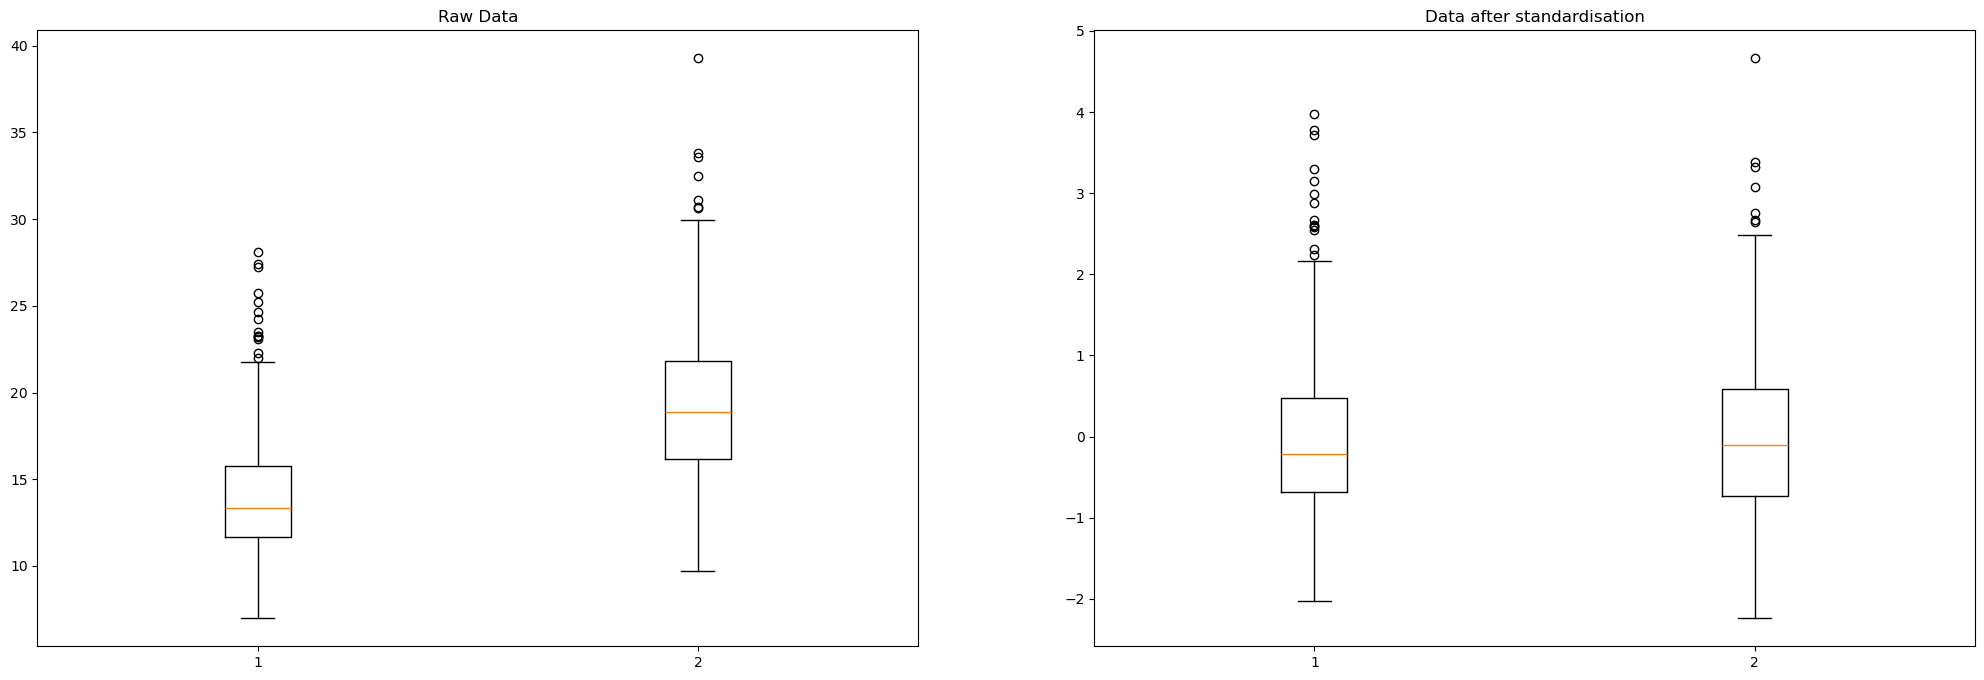

In [3]:
# get the data, we'll just grab 2 dimensions
X = cancer.iloc[:, 2:4].to_numpy()
Y = cancer.iloc[:, 1].astype("category").cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

We'll split our data into training and testing, with 70% for training and 30% for testing. We can do that using a function in sklearn that will split the data for us. Note that if we use a different value of random_state, we'll get a different split (and thus we'll probably get slightly different evaluation results).

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

## Support Vector Machines (SVMs)

We'll start with support vector machines. These seek to find a plane that divides the data into two classes. We can also (optionally) use a kernel to transform the data, projecting it into a higher dimensional space such that the data is (or might be) easier to separate. Some things to note with SVMs include:
* Kernel choice can have a big impact on performance. Often data is not linearly separable (particularly when we have small numbers of dimensions), kernels can help greatly here.
* We need to be careful not too add too much complexity with our kernel, it is easy to overfit. Using appropriate training/testing spilts can help avoid this.
* Class imbalance can impact performance. We can adjust error costs to compensate, such that classification errors for the rare class are higher. Errors should be inversly proportional to the split (i.e. if we have twice as many examples of class 1 as of class 2, then the cost of an error when classifying class 2 should be twice that for class 1)

### An Evaluation Function

Before we get into the weeds on the classifiers, we'll create a little function to do some evaluations for us. This will:
* create a figure
* draw a confusion matrix for the trainign data in a sub-fig on the left
* draw a confusion matrix for the testing data in a sub-fig in the middle
* compute the overall classification accuracy on the training and testing data and set that to our figure titles
* draw the decision boundary in a subplot on the right

This has simply been created as we're going to do this for each test that we run, and so avoids a lot of 
copy/pasting. The decision boundary part of this function is also the reason that we standardised the data as it ensures that each dimension has a similar range. If you want to explore these boundaries further, things you could consider are:
* using a smaller value for the step in the numpy.arange commands to get a finer grid of points and more detail in the contour
* expanding the contour beyond the min and max to get a sense of how the model will extrapolate

In [5]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 3, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 3, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    
    mins = numpy.min(X_train, 0)
    maxs = numpy.max(X_train, 0)
    xx, yy = numpy.meshgrid(numpy.arange(mins[0], maxs[0], 0.025),
                     numpy.arange(mins[1], maxs[1], 0.025))

    Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = fig.add_subplot(1, 3, 3)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=20, edgecolor='k')

Let's start with a default model and see what we get. This will use:
* A linear kernel
* A box-constraint of 1

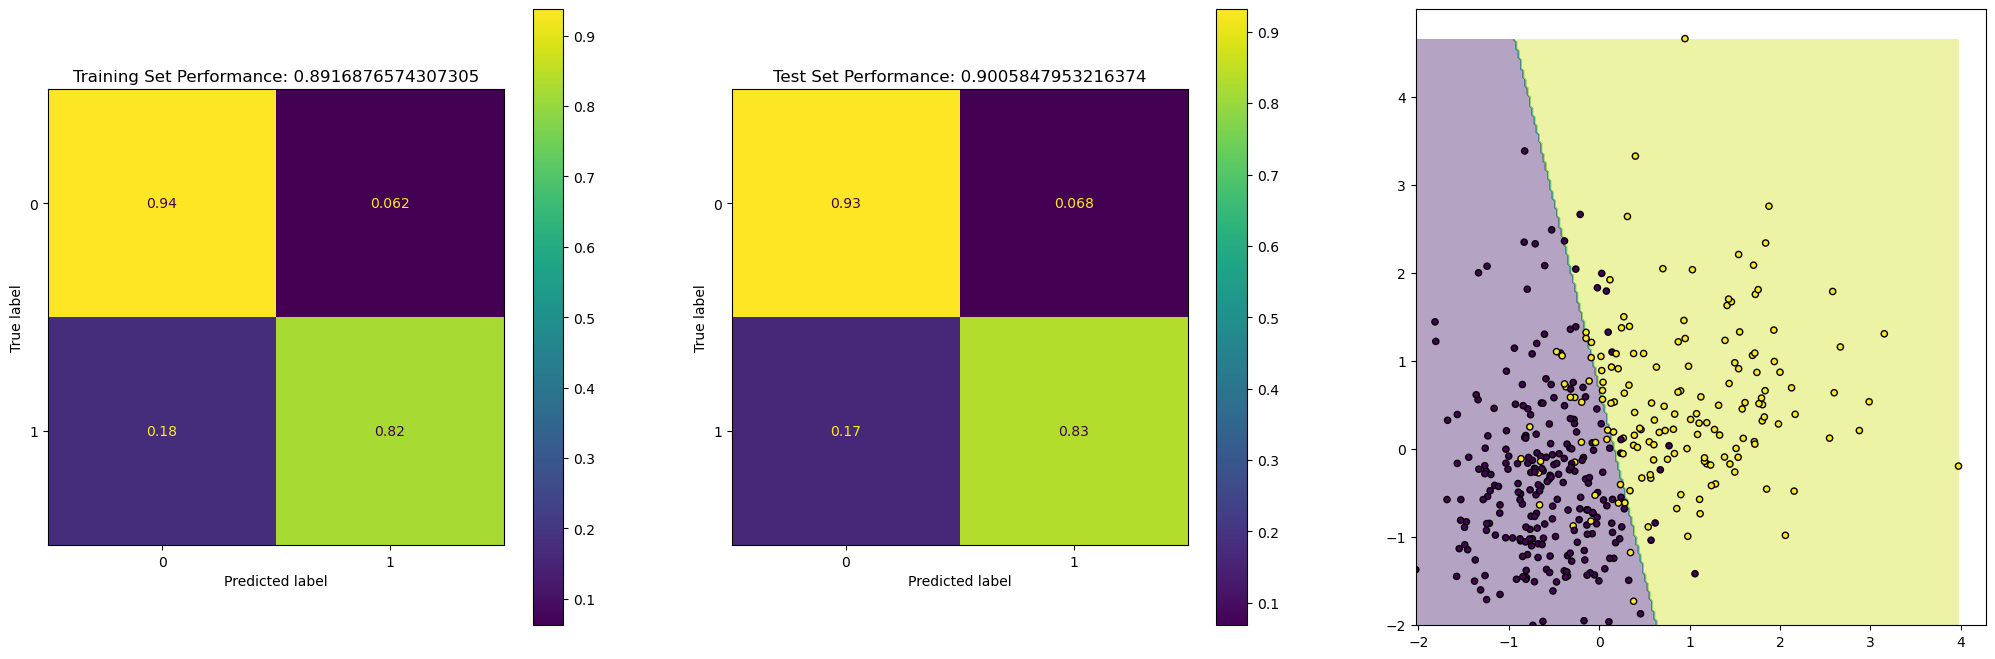

In [6]:
svm = SVC(C=1.0, kernel='linear')
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

Before we go any further, let's quickly look at the confusion matricies. These show:
* the true class on the vertical axis
* the predicted class on the horizontal axis

Ideal performance would be to have 100% along the diagonal that runs from top-left to bottom-right corners, and 0 everywhere else.

Considering the plot for the test set (the middle plot), we see that:
* when the true class is 0 (top row), we predict the class as 0 93% of the time (top left cell)
* when the true class is 0 (top row), we predict the class as 1 (i.e. make an error) 6.5% of the time (top right cell)
* when the true class is 1 (bottom row), we predict the class as 0 (i.e. make an error) 17% of the time (bottom left cell)
* when the true class is 1 (bottom row), we correctly predict the class as 1 83% of the time (bottom right cell)

One thing we don't get of sense of in this is how many samples we have in each class, though we can change the options that we give to `ConfusionMatrixDisplay` to show raw counts as well if we want (i.e. how many samples are correct, incorrect, etc). Confusion matricies are very useful for evaluating classifier performance, as they give a sense of the accuracy on each class and where the classifier makes errors. Here for example, we can see that we're better at classifying class 0 than class 1. This become more powerful for multi-class tasks (see the next example), but are still useful here. 

On the whole, the model works pretty well. It doesn't seem to be overfitting, as we're getting pretty similar performance on training and testing data.

Considering the decision boundary, we see that:
* our boundary is a straight line, this makes sense, as we have a linear SVM
* most points are the correct side of the line, though there are some errors. That said, our line seems to go through the middle (more or less)

As we change our model parameters (hyper-parameters), we'll see a big change in boundaries. Let's try some RBF and polynomial kernals. 

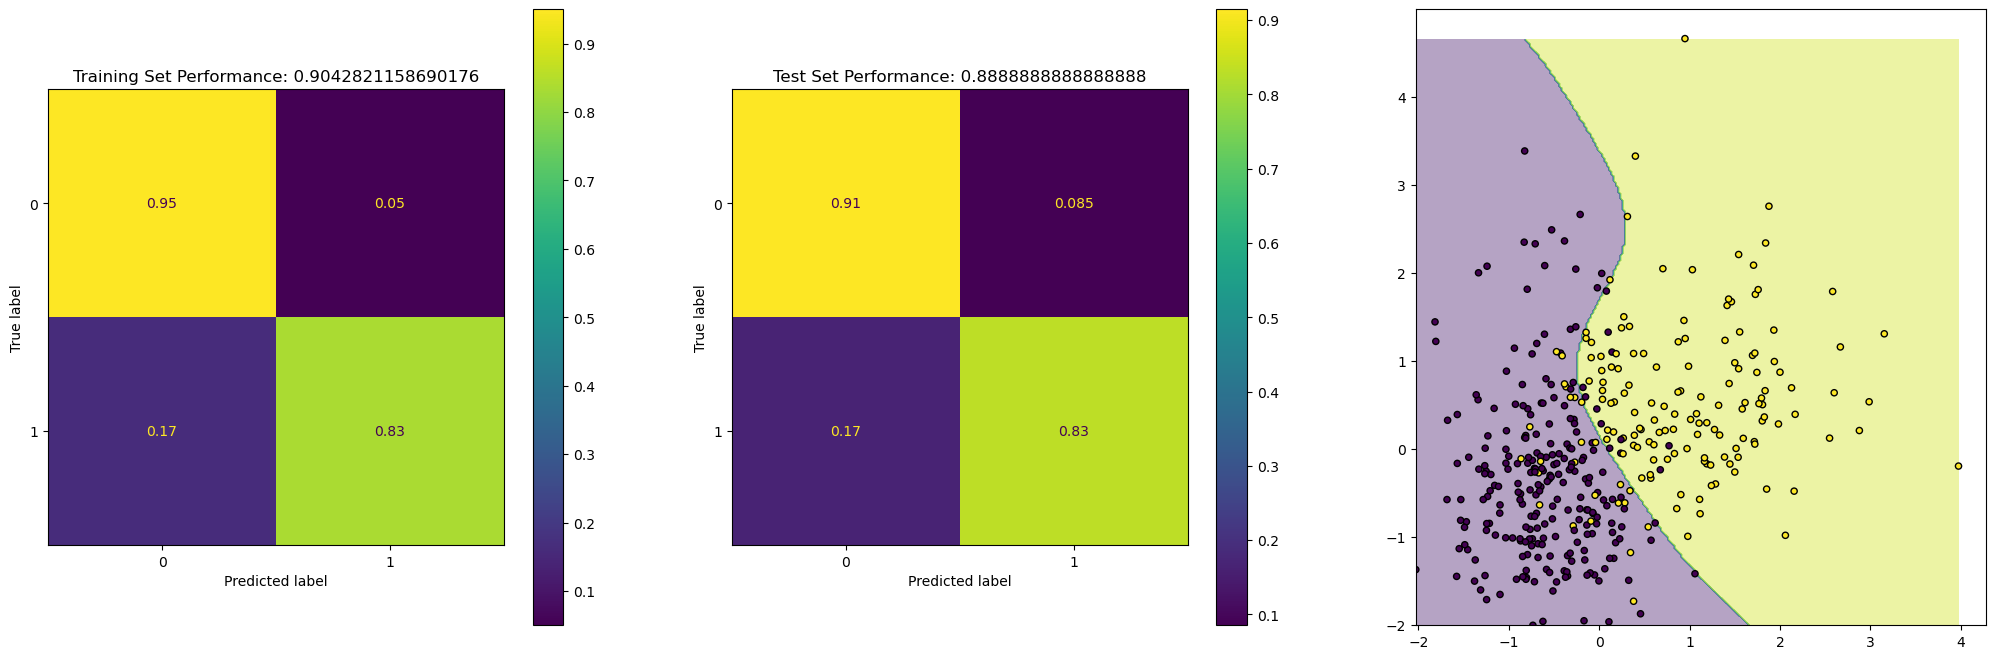

In [7]:
svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

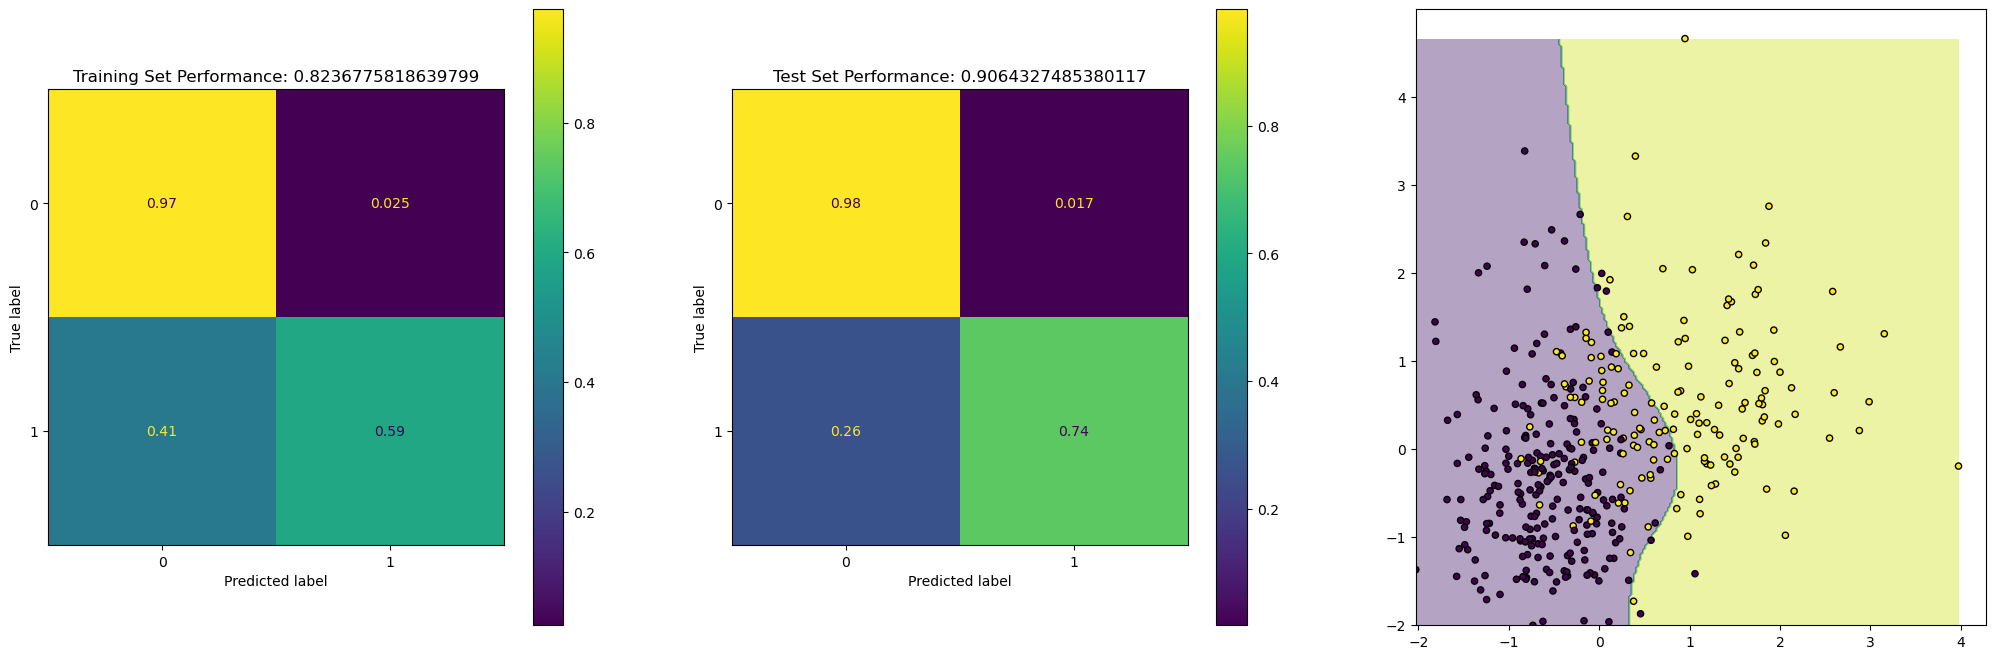

In [8]:
svm = SVC(C=1.0, kernel='poly')
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

Looking at these, our boundary is a bit more interesting than the linear case, but performance is not necessarily better, with all models performing similarly.

Given that all these models seem to be close to the same, how do we pick the optimal parameters? Ideally, we search over the hyper-parameter space. For an SVM, this means:
* Values of C
* Different kernels
* Kernel parameters

We can do this with either lots of cut and paste, some nested loops, or by using hyper-parameter optimisation tools. We'll start with a grid search, which will try all possible combinations of values from a set that we provide. In this case, we'll be fairly exhaustive and try the three kernels, 6 different values of C, and some different kernel parameters for our RBF and Polynomial kernels. As we have different parameters for different kernels, we'll create three grids, one for each kernel.

In [9]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, Y_train)
grid_search.cv_results_

{'mean_fit_time': array([1.07979774e-03, 1.03006363e-03, 1.41525269e-03, 5.08761406e-03,
        3.66988659e-02, 1.46813393e-03, 1.84726715e-03, 1.84578896e-03,
        1.84321404e-03, 1.10011101e-03, 1.40500069e-03, 1.84283257e-03,
        1.84378624e-03, 1.04761124e-03, 1.15742683e-03, 1.39970779e-03,
        1.84583664e-03, 1.38540268e-03, 1.19438171e-03, 1.15747452e-03,
        1.38883591e-03, 5.48610687e-03, 1.47614479e-03, 1.25598907e-03,
        1.13654137e-03, 1.28631592e-03, 1.97076797e-03, 1.42059326e-03,
        2.79150009e-03, 1.30133629e-03, 3.04722786e-03, 1.59273148e-03,
        7.21340179e-03, 1.68204308e-03, 1.09807491e-02, 2.96950340e-03,
        5.54365635e-02, 6.16831779e-03, 6.34089947e-02, 2.65438080e-02,
        4.84375525e-01, 5.58725834e-02, 7.31763029e-01, 1.47516870e-01,
        3.09289188e+00]),
 'std_fit_time': array([9.29071653e-05, 4.78209904e-05, 7.46582950e-05, 2.91858280e-03,
        3.34381712e-02, 1.65280316e-05, 1.76494174e-06, 8.70459669e-06,
     

We get a lot of numbers out of this which we can trawl through as much as we want. The most useful details are:
* the rank_test_score at the bottom, which gives us the order of which system is best
* the mean_test_score and std_test_score arrays that tell us the performance of the system across multiple folds
* and params, which gives us the model parameters

From this, we can easily select out the best system and train that up, and see how it goes.

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


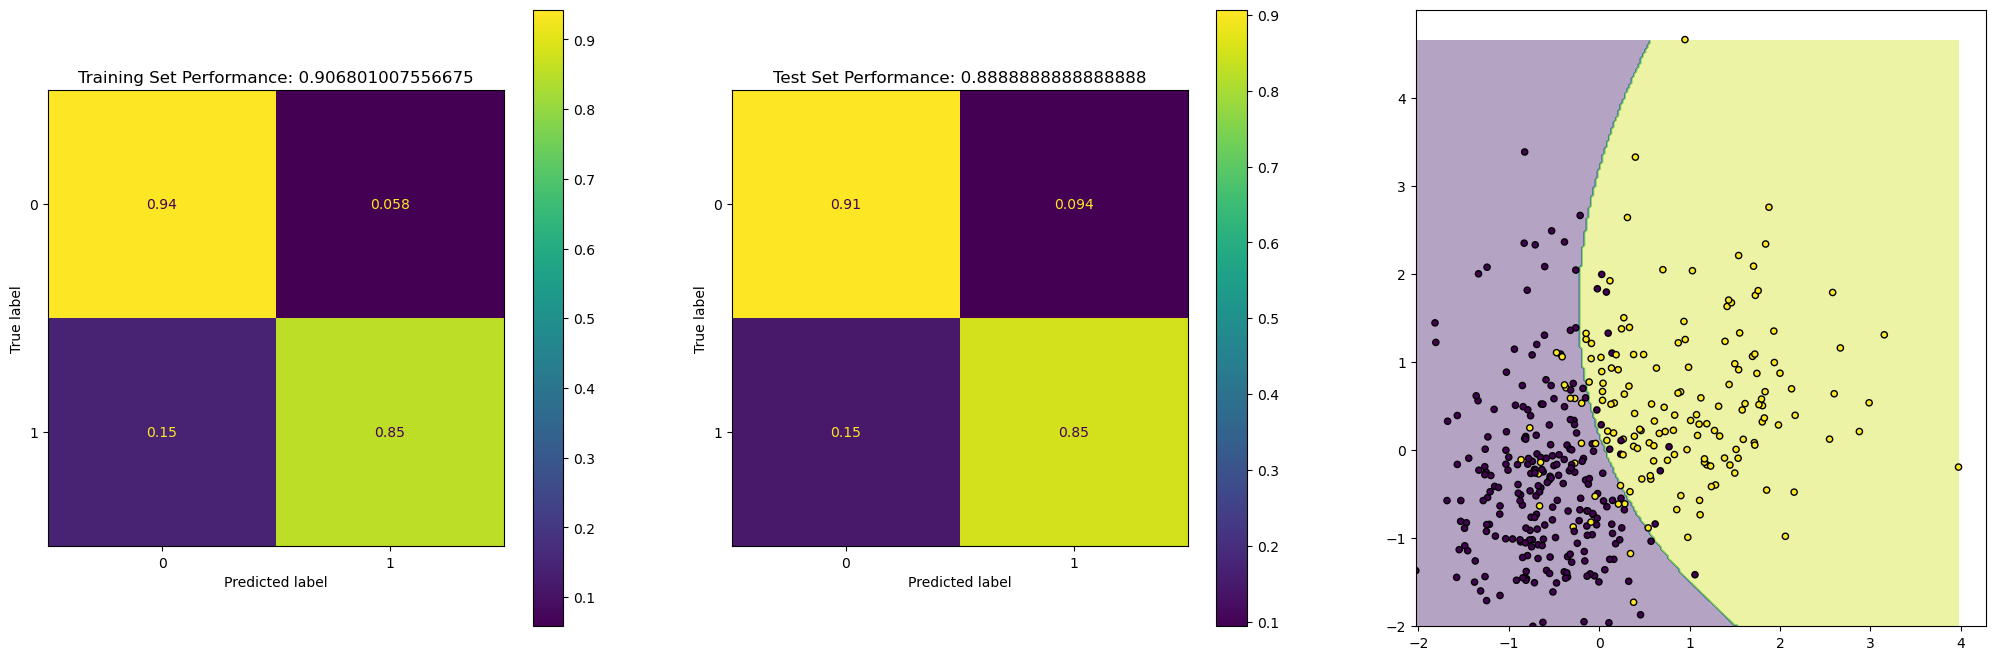

In [10]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

We end up with something much like we had before. This is not unsurprising, as that was already working pretty well.

While this isn't too dramatic on this data, in other cases where the data is more complex this can make a big difference. However care must be taken to ensure that you don't make your grid search too big, as you can easily end up with a search that takes hours to complete. If we wanted to take this further, we could re-run this search with a finer grid around the location where we found the best performance, and continue in a coarse to fine manner.

## K-Nearest Neighbours Classifier
We'll now shift to our second method, K-Nearest Neighbours classification:
* K-nearest neighbours is a classificaiton method based on the idea of clustering: points that are near each other will belong to the same class
* It can model very non-linear decision boundaries
* Trivial to extend to multi-class classification
* But, it's sensitive to noise and outliers
* Does not allow and easy way to work our what dimensions are important (no p-values)
* Can run into problems when we have an uneven class distribution (i.e. not equal amounts of each type of output)

In it's most basic form, cKNN is pretty straight forward to use:

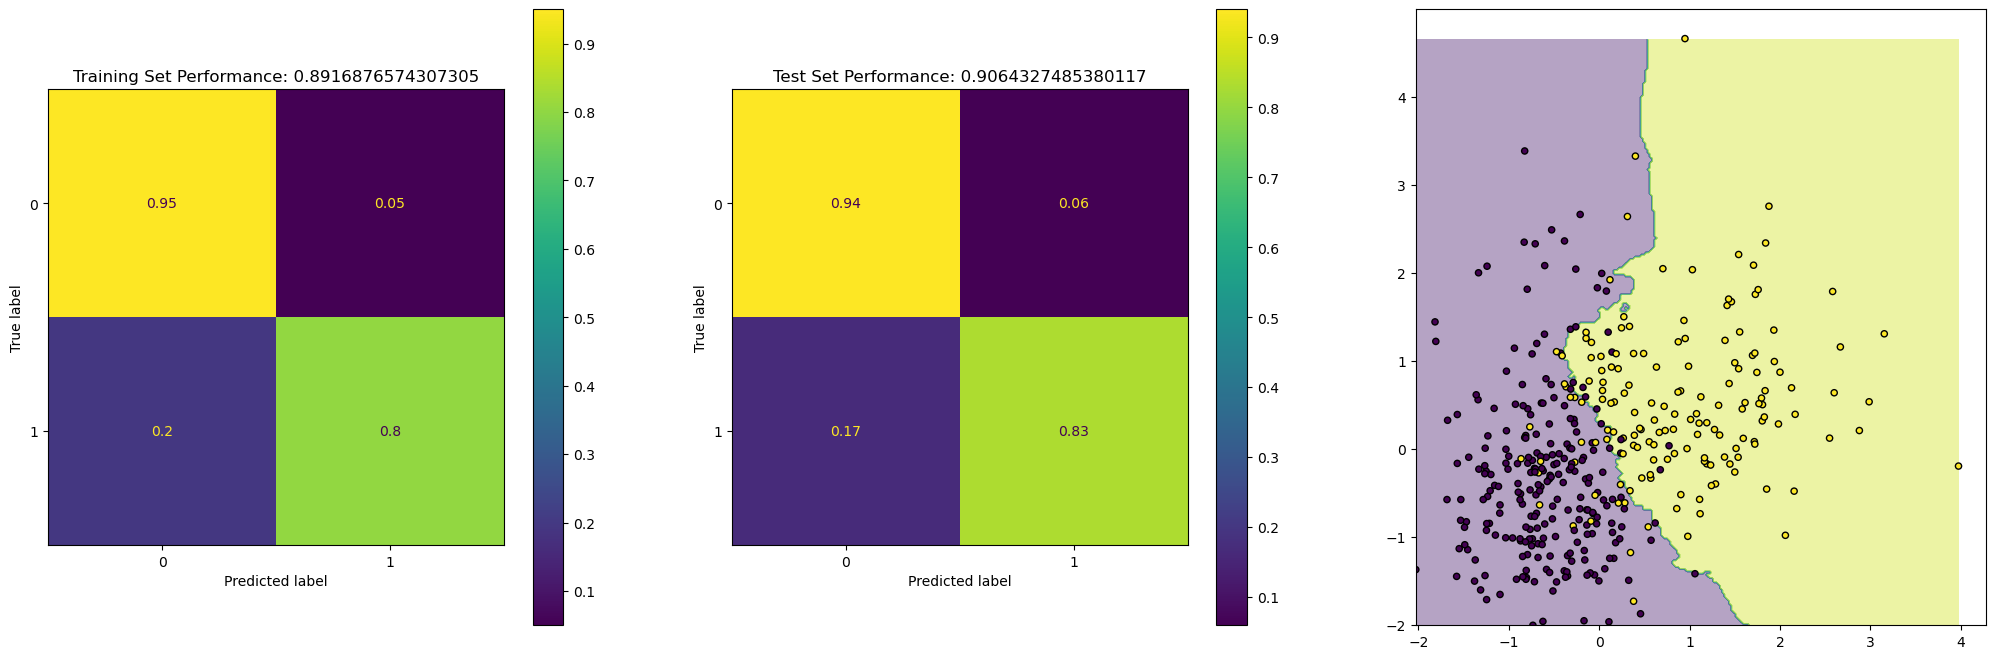

In [11]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

The one parameter we need to be most careful with is our number of neighbours, $K$. If we set this to something silly, we can see we end up in trouble.

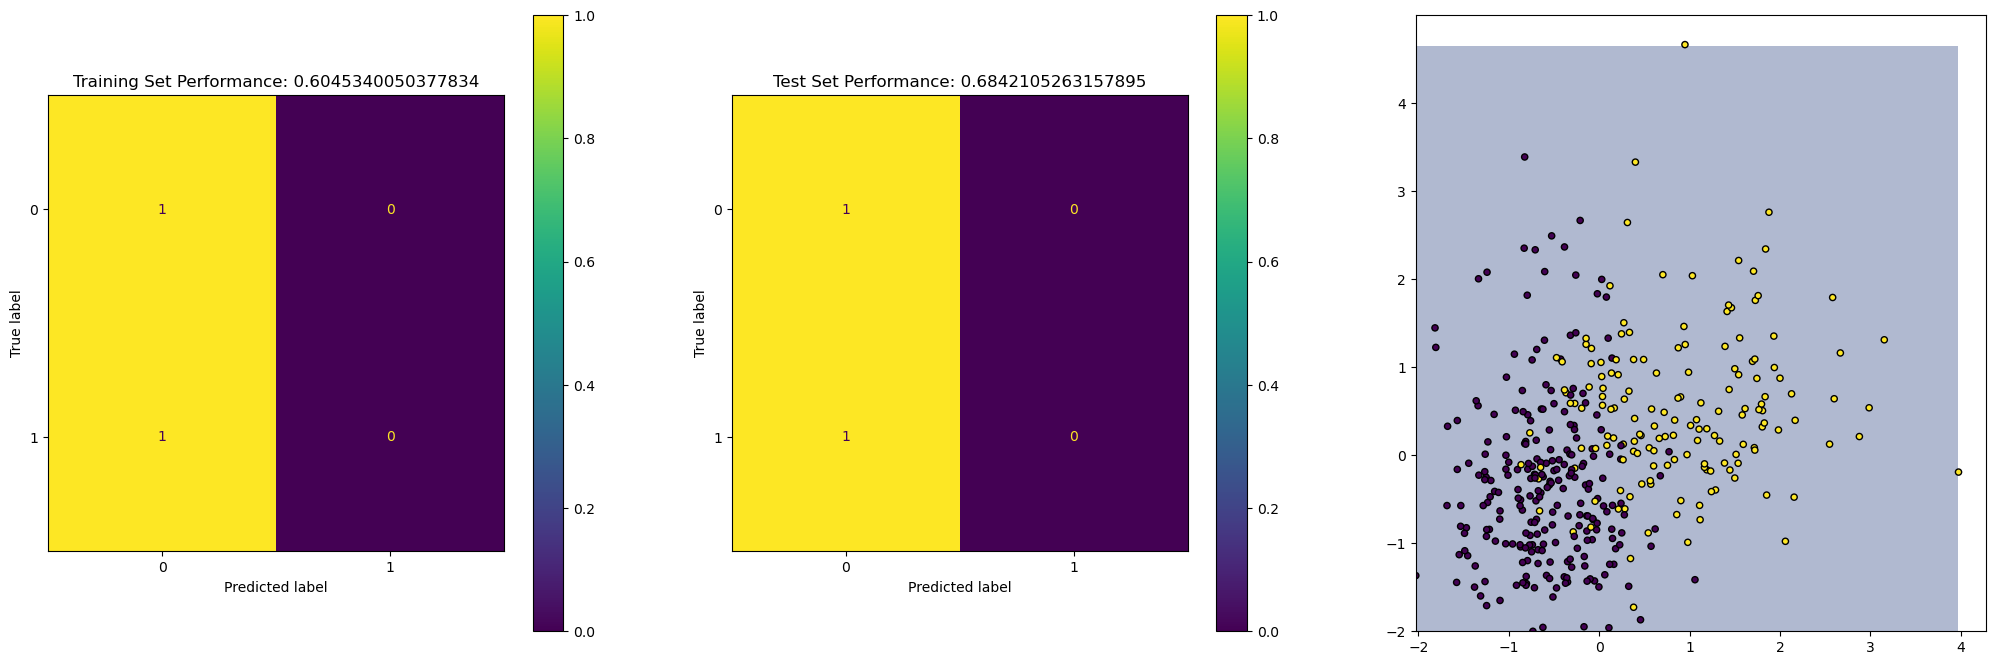

In [12]:
cknn = KNeighborsClassifier(n_neighbors=350, weights='uniform')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

This is a fairly extreme case, but when we have more than two classes (see the next example) with a large imbalance between them (i.e. very different numbers of samples for each) we can end up this sort of issue a lot easier. What has happened here is our number of neighbours is more than twice the number of examples that exist for one class. To classify a point as a given class, more than half the neighbours for that point have to belong to the class. However we're now in a situation where for one of our two clases, it's not possible to have more than 50% of the neighbours belonging to one of the classes. As we have a two-class problem, that means that every point gets classified as the majority class.

We can help avoid this by using distance based weighting.

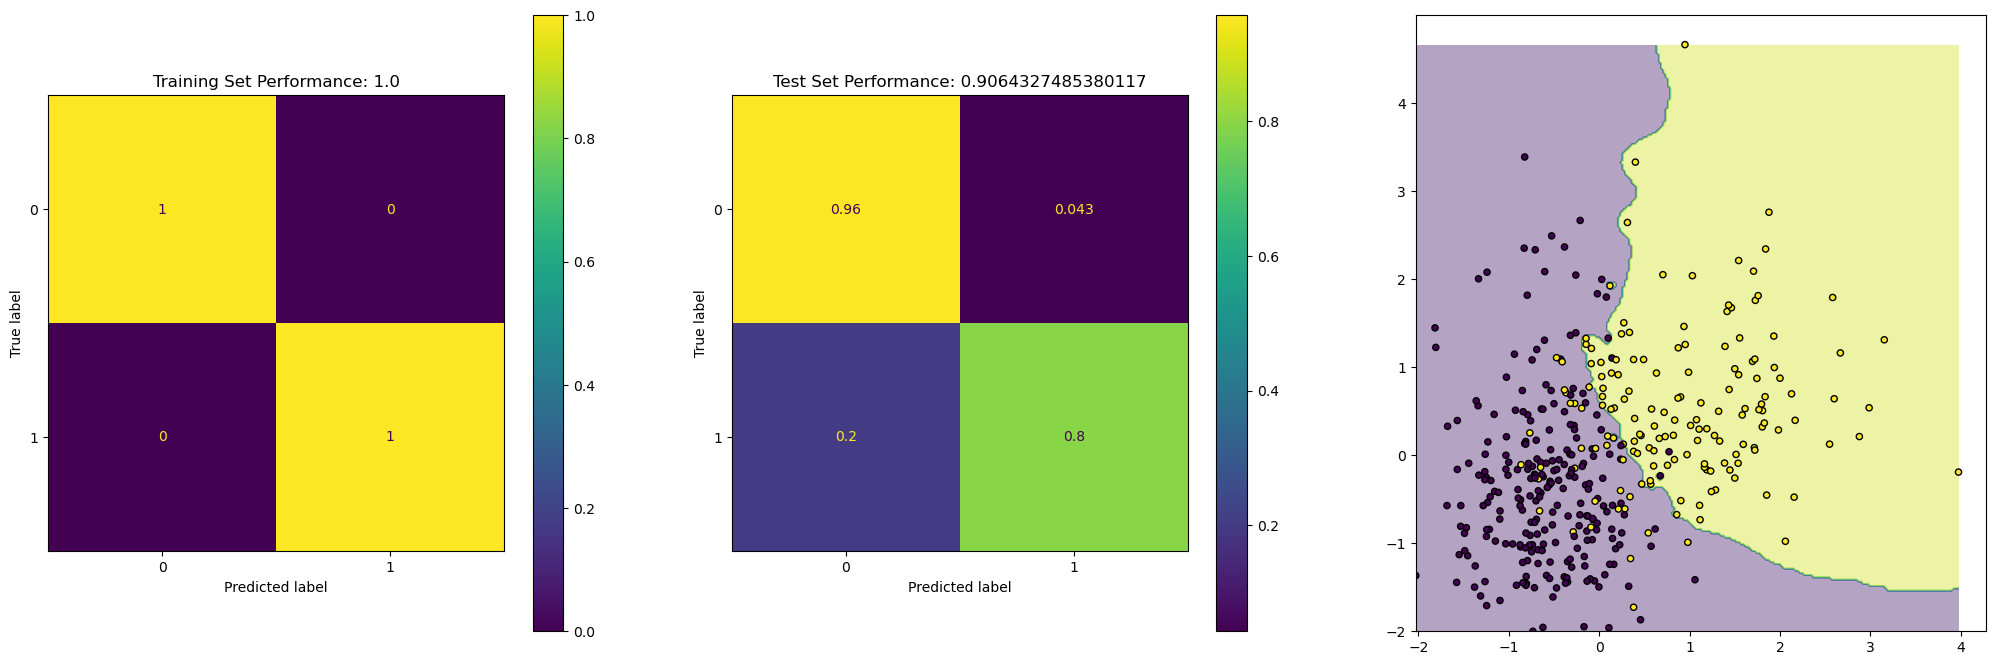

In [13]:
cknn = KNeighborsClassifier(n_neighbors=350, weights='distance')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

Note that when we use distance based weighting, our performance on the training set is perfect. This is to be expected, as when get the set of closest neighbours, one of the neighbours will be the actual point (i.e. the distance between the neighbor and the point to classify will be 0).

Once again, we can use hyper-parameter optimisation to help things along. This time, we'll use the randomised search, which will sample parameter combinations to use rather than exhaustively searching. 

In [14]:
cknn = KNeighborsClassifier()
params = {'n_neighbors' : list(range(1,21)), 'weights' : ['uniform', 'distance']}
rand_search = RandomizedSearchCV(cknn, params, n_iter=20)
rand_search.fit(X_train, Y_train)
print(rand_search.cv_results_)

{'mean_fit_time': array([0.00040708, 0.00034122, 0.00032749, 0.0003336 , 0.00033374,
       0.00035224, 0.00035491, 0.00035205, 0.00034714, 0.00036125,
       0.00034184, 0.00034742, 0.00035276, 0.00033917, 0.0003346 ,
       0.00033388, 0.00032668, 0.00033197, 0.00034604, 0.00035114]), 'std_fit_time': array([9.87815792e-05, 6.71545194e-06, 3.17947065e-06, 7.64784965e-06,
       2.69486831e-06, 7.61089466e-06, 5.34950940e-06, 9.98583993e-06,
       1.56704681e-05, 2.54451496e-05, 5.46472859e-06, 1.43775695e-05,
       9.21986563e-06, 8.00972885e-06, 9.58620596e-06, 5.68936872e-06,
       3.79797130e-06, 8.36519709e-06, 8.57723886e-06, 8.43125767e-06]), 'mean_score_time': array([0.00241551, 0.00074182, 0.00061069, 0.00069265, 0.00059195,
       0.00220933, 0.00215406, 0.00220556, 0.00075841, 0.0022326 ,
       0.00065551, 0.00225892, 0.00214553, 0.00081701, 0.00073824,
       0.00069575, 0.00063753, 0.00073867, 0.00220594, 0.00225034]), 'std_score_time': array([1.65693303e-04, 6.5284492

The output of this is a similar mess to what we had earlier, and once again we can select the best system from the results and use that.

{'weights': 'uniform', 'n_neighbors': 17}


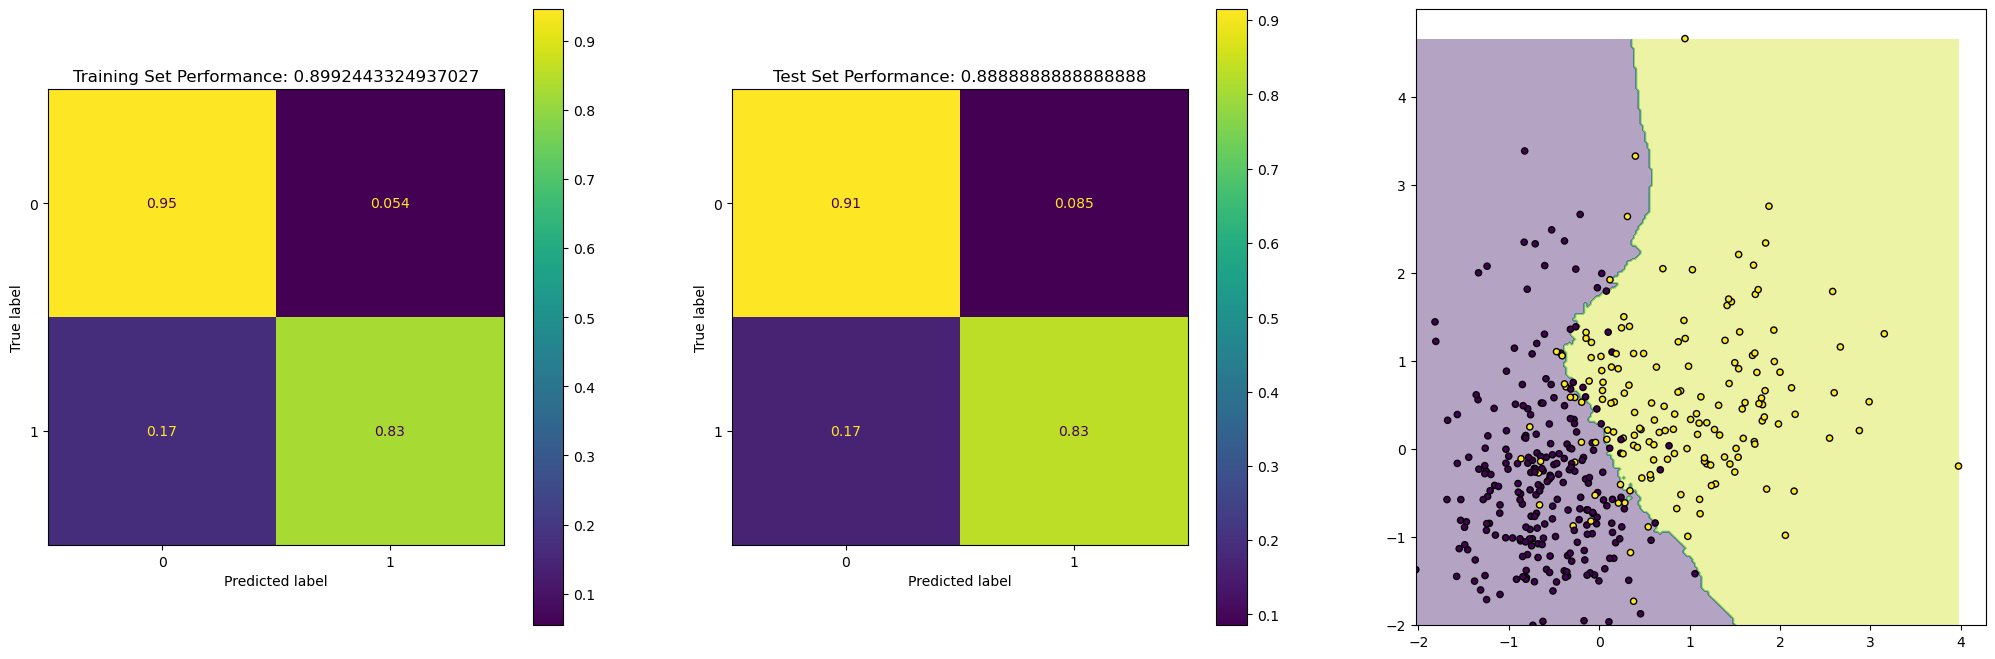

In [15]:
best_system = numpy.argmin(rand_search.cv_results_['rank_test_score'])
params = rand_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

Running this repeatedly will see variation, as we're not sampling every possible configuration, however the value of n_iters can be increased to sample more points, which will help (but not guarantee) consistency.

## Random Forest Classifier

Finally, let's look at the random forest. We'll start with 100 estimators (trees), and a max tree depth of 4.

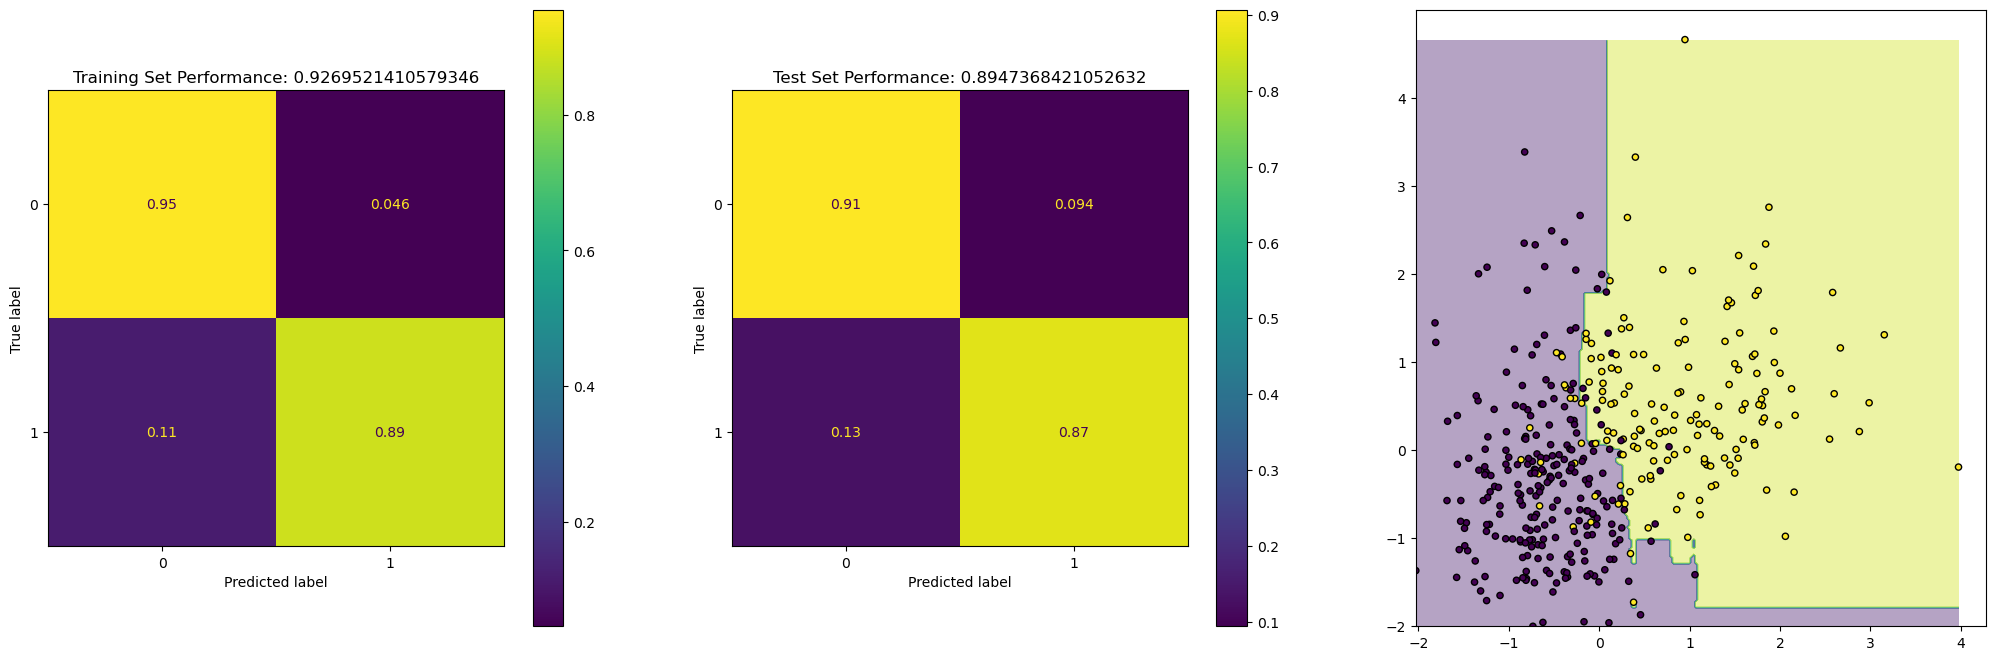

In [16]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

Performance wise, our model is pretty similar to the others.

It's important to remember than the random forest is not one classifier, but a collection of them from which we take a concensus result. We can actually get access to the individual models if we want.

In [17]:
print(rf.estimators_)

[DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=209652396), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=398764591), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=924231285), DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1478610112), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=441365315), DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1537364731), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=192771779), DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1491434855), DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1819583497), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=530702035), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=626610453), D

And we can even make predictions with them, and pass them to our evaluation function to visualise what's going on.

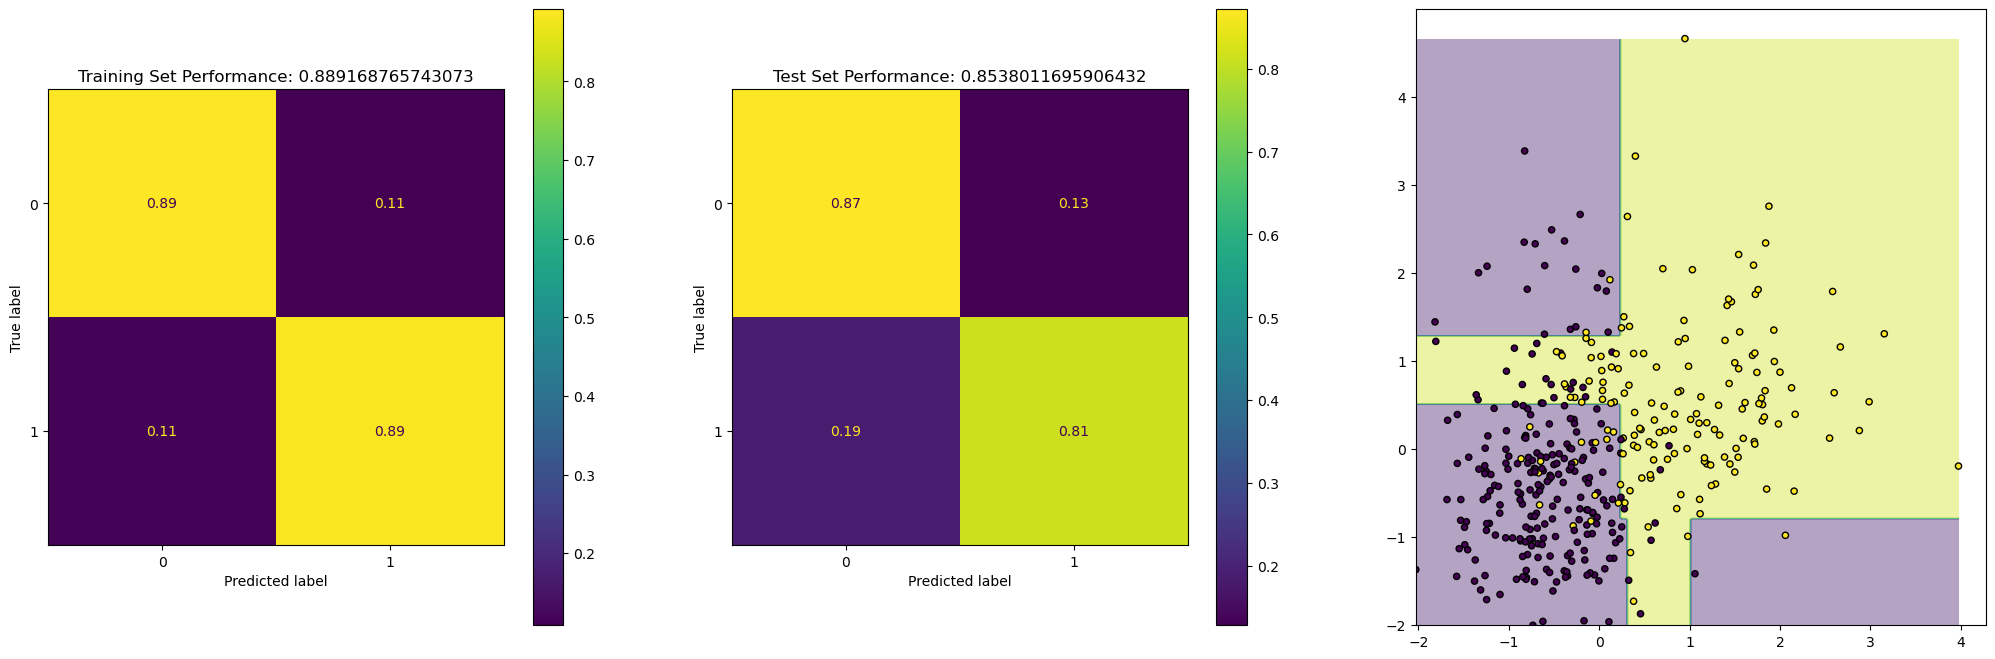

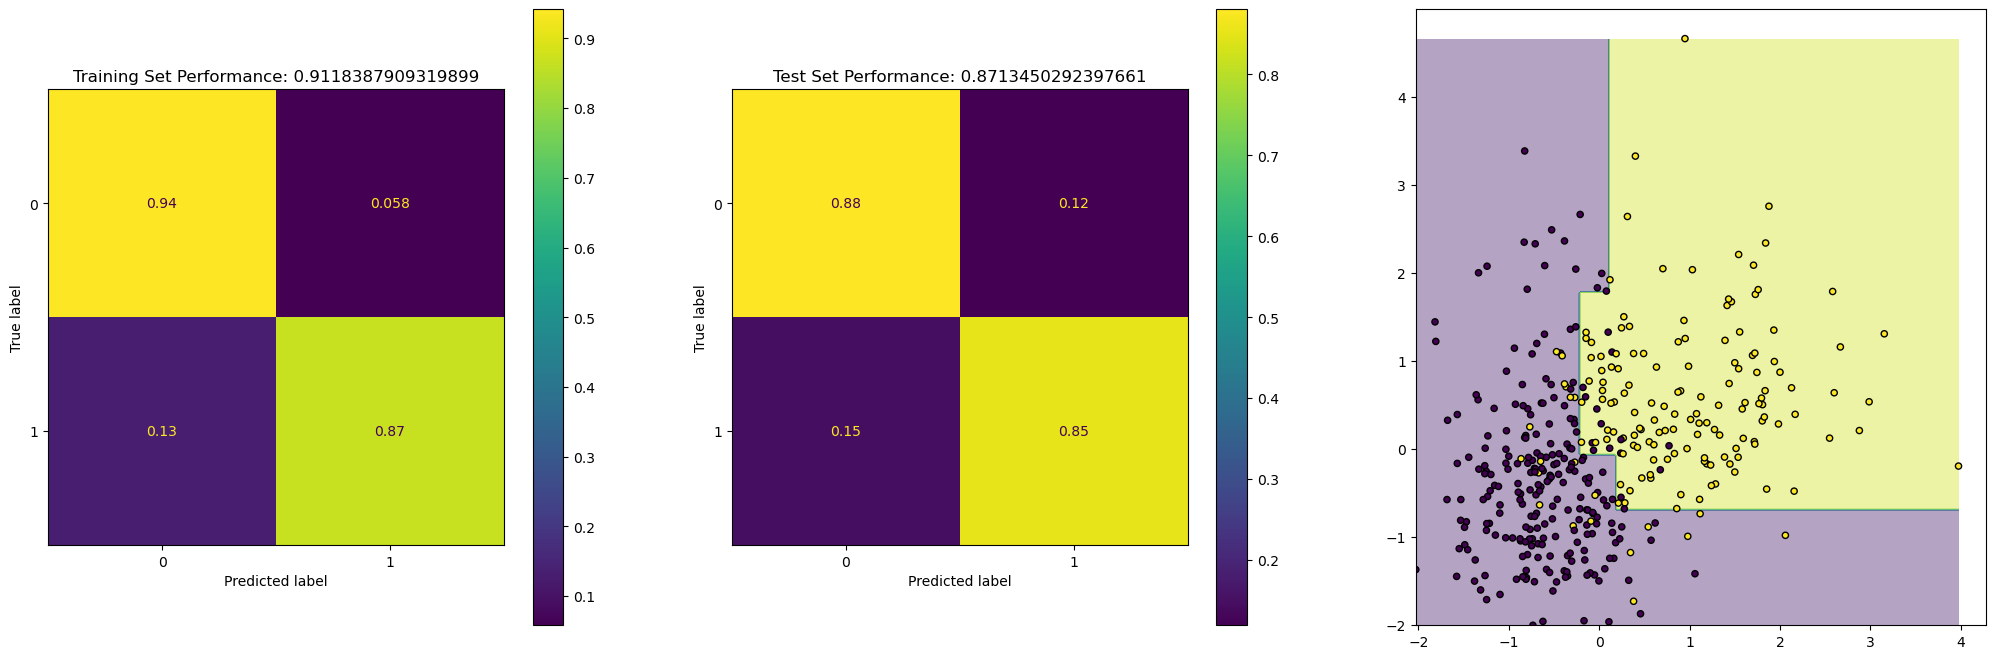

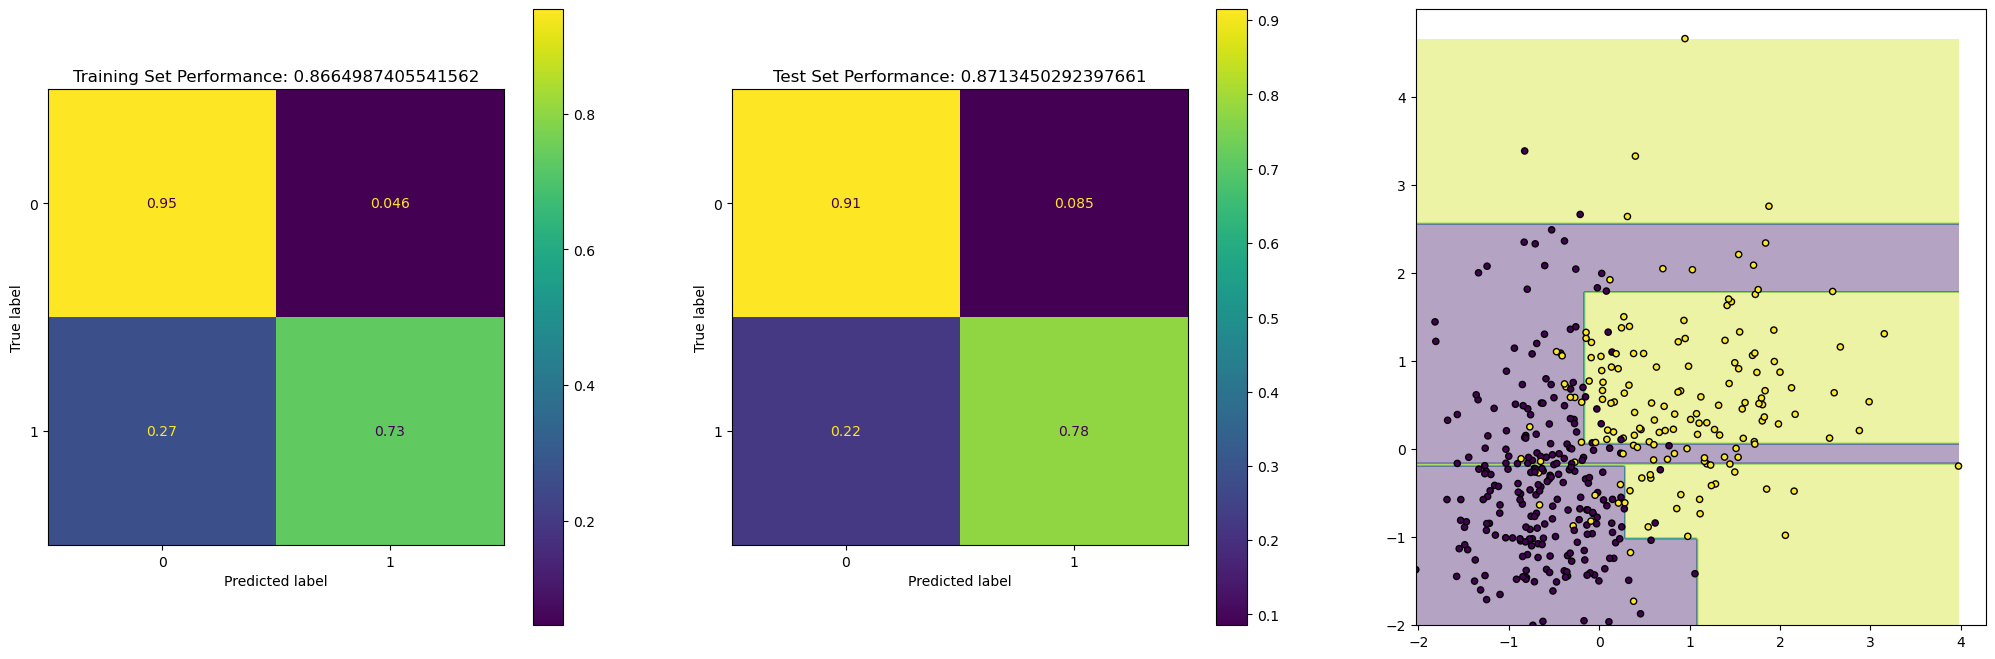

In [18]:
eval_model(rf.estimators_[0], X_train, Y_train, X_test, Y_test)
eval_model(rf.estimators_[4], X_train, Y_train, X_test, Y_test)
eval_model(rf.estimators_[42], X_train, Y_train, X_test, Y_test)

What we see is that each of these trees is behaving quite differently. Keep in mind that each tree is trained on a different subset of the data, which accounts for the variation seen. 

We can also visualise the trees to see the decision path - though keep in mind that this get's very challenging with deep trees.

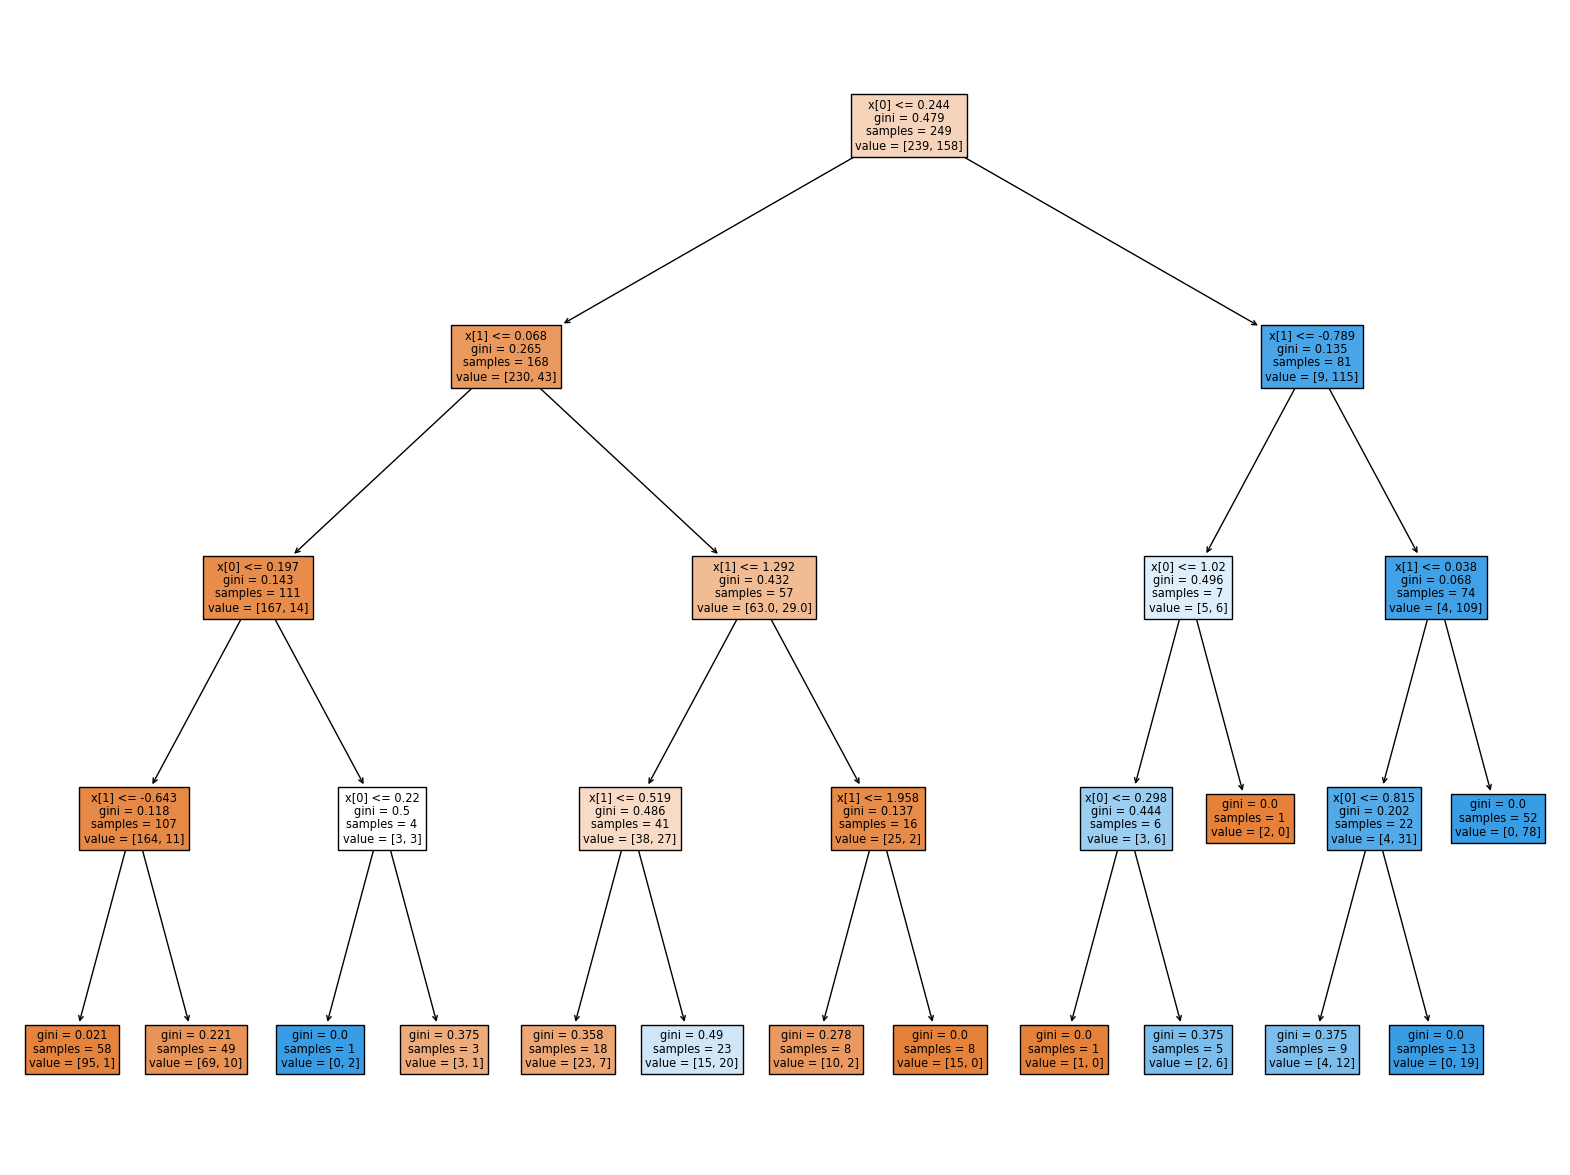

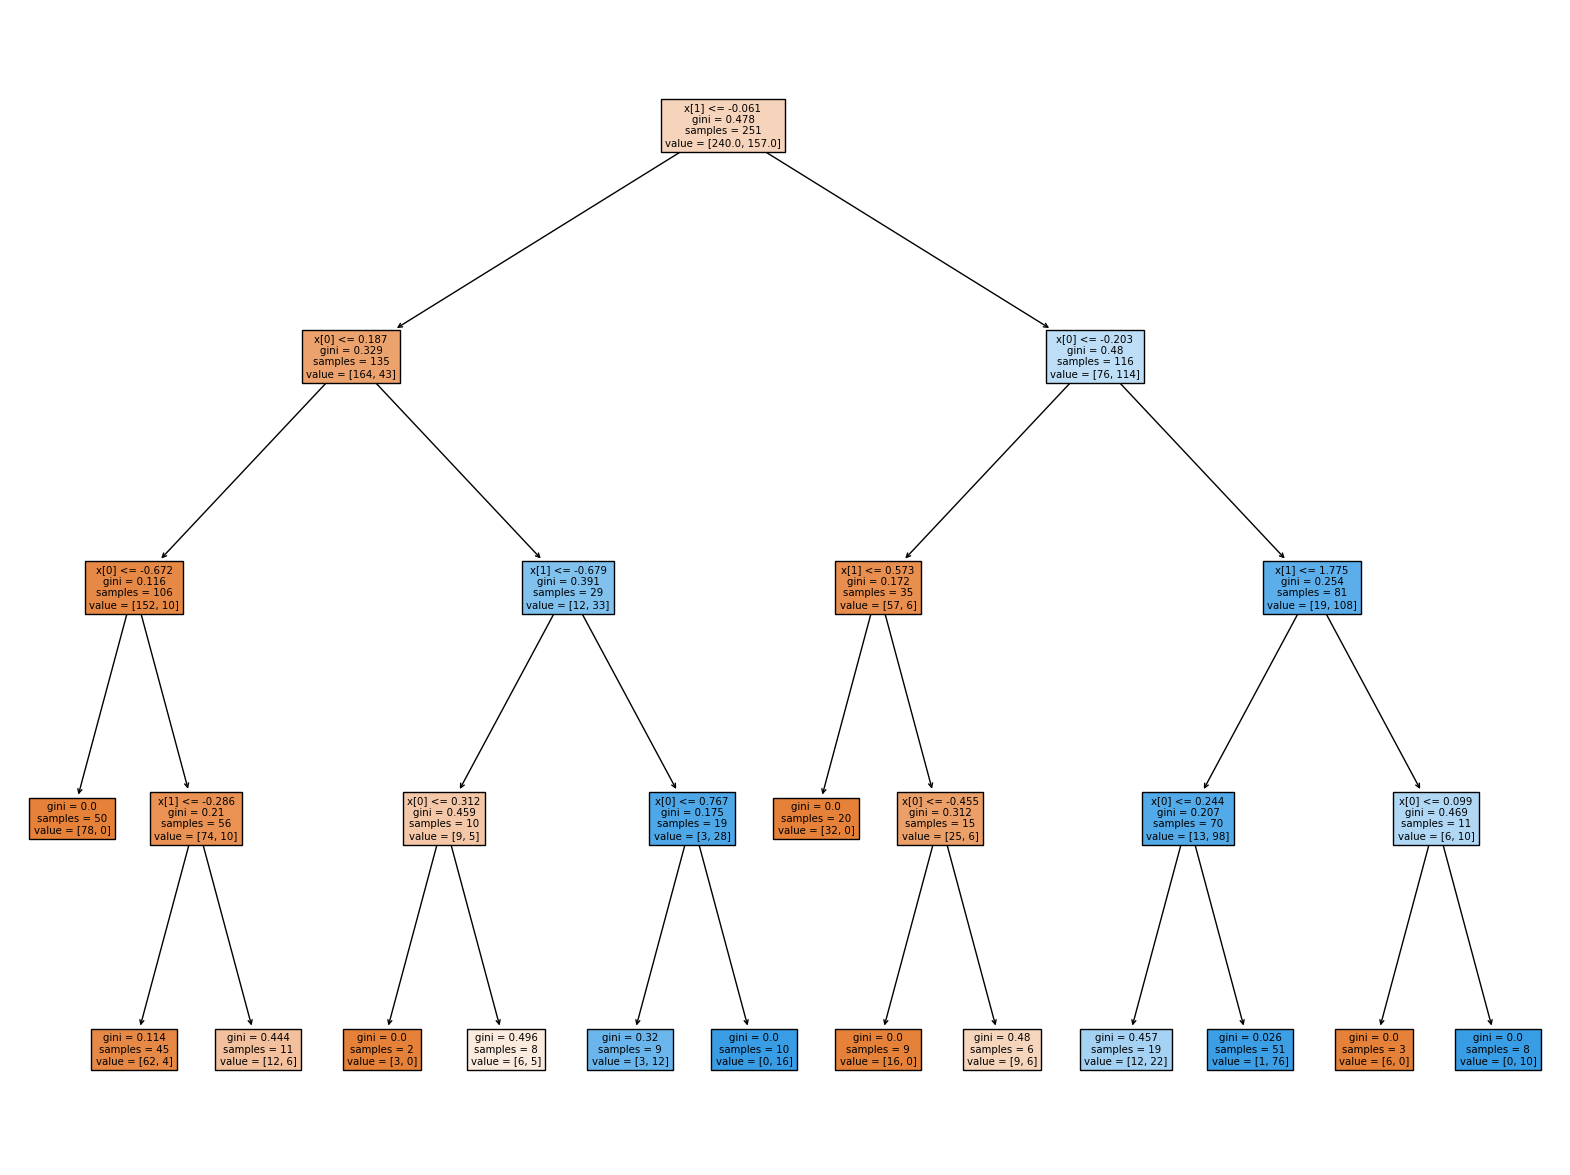

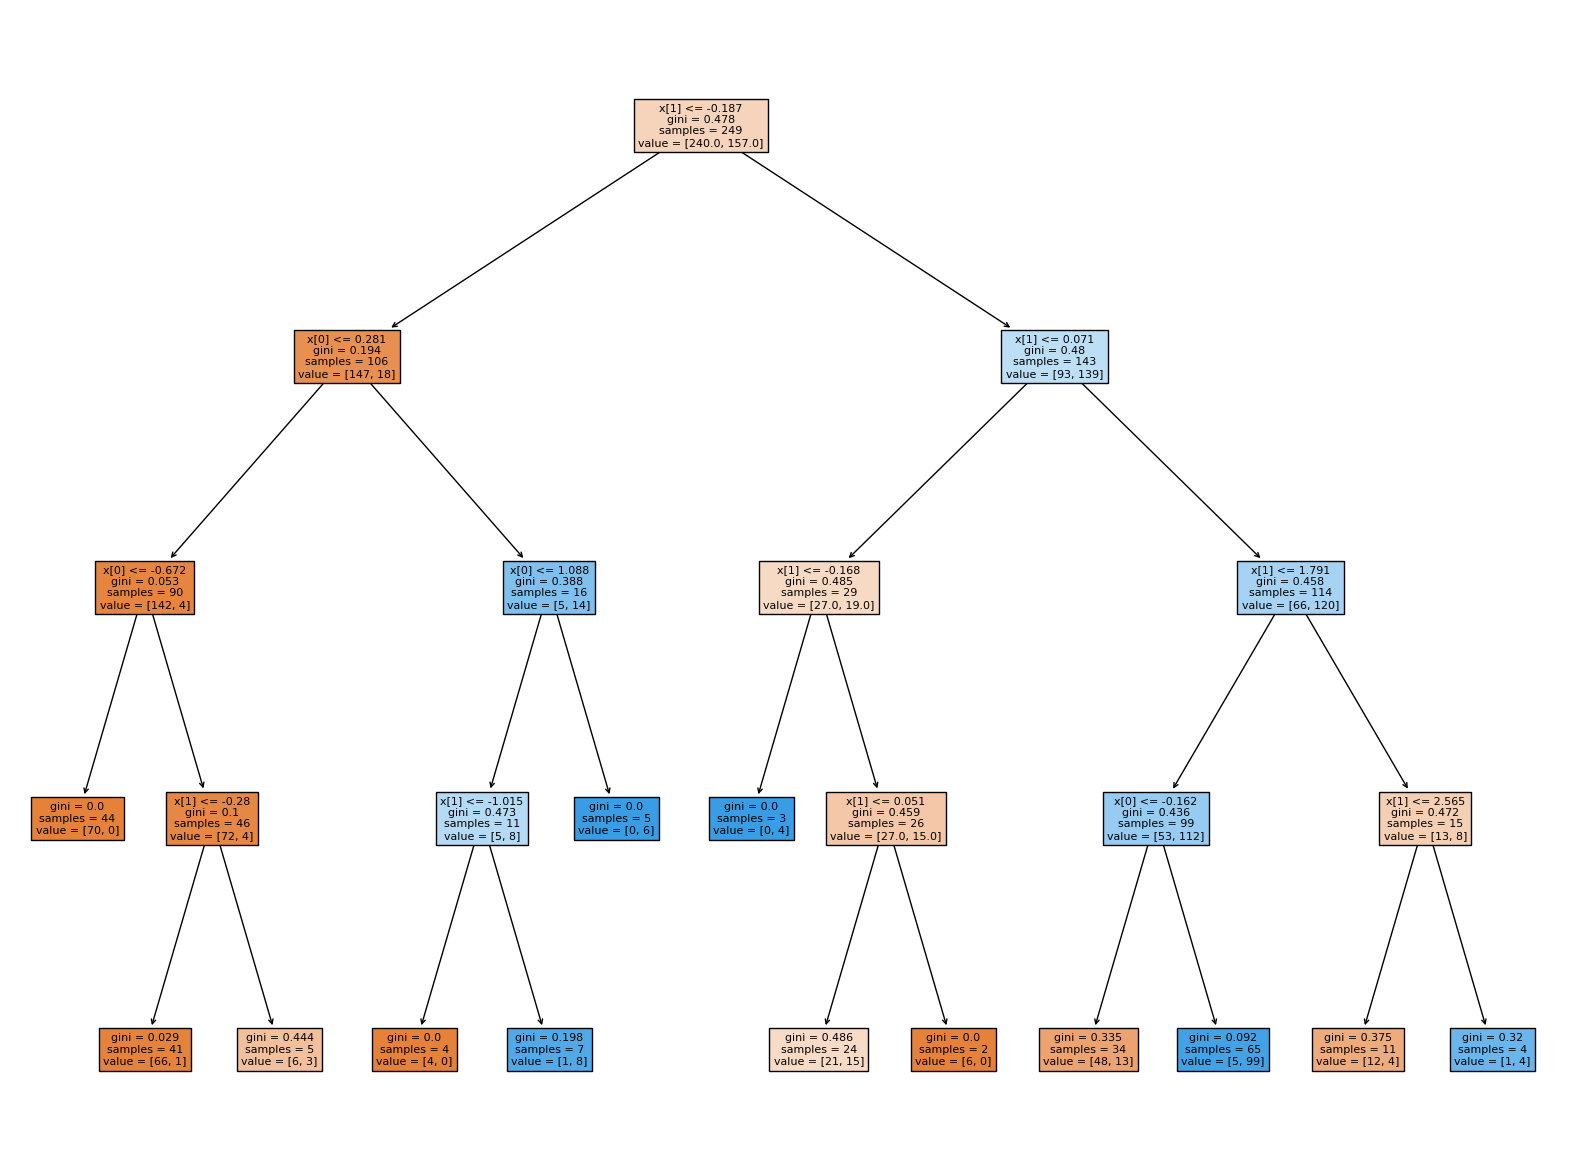

In [19]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[0], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[4], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[42], filled=True) 

For the sake of completeness, let's have a small play with optimising the forest, and this time we'll use the Halving Grid Search method. This works a bit differently to our other methods, and it will start by evaluating all systems on a small sample of data. It will then take only the best half of the systems and evaluate them on a larger sample. This repeats, until it evaluates just the best pair of systems on all the data to work out which configuration is best.

In [20]:
rf = RandomForestClassifier(random_state=42)
param_grid = {'max_depth': [2, 4, None], 'min_samples_split': [5, 10], 'n_estimators' : [25, 50, 100]}
halving_search = HalvingGridSearchCV(rf, param_grid, random_state=0).fit(X_train, Y_train)
print(halving_search.cv_results_)

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 2, 2]), 'n_resources': array([ 44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,  44,
        44,  44,  44,  44,  44, 132, 132, 132, 132, 132, 132, 396, 396]), 'mean_fit_time': array([0.01510715, 0.02929378, 0.05801668, 0.01506228, 0.0292459 ,
       0.05713625, 0.01512303, 0.02914701, 0.05749078, 0.0149549 ,
       0.02899404, 0.05722046, 0.01517487, 0.02918582, 0.05772614,
       0.0149981 , 0.02910857, 0.05752172, 0.05974193, 0.03058324,
       0.06021776, 0.01552305, 0.0301908 , 0.05961852, 0.03455472,
       0.06814618]), 'std_fit_time': array([1.67931663e-04, 1.89442368e-04, 2.25215778e-04, 1.24090895e-04,
       1.07523068e-04, 1.44995776e-04, 4.94304049e-04, 4.02771807e-04,
       2.37796181e-04, 2.00980363e-04, 8.52558170e-05, 1.99893071e-04,
       2.72678611e-04, 1.14152107e-04, 4.31358817e-04, 1.00750241e-04,
       8.17615699e-05, 1.21657000e-04, 8.50136030e-04, 1.104289

From the above output, we can see the grid search performs three iterations. From the results of the last iteration, the best performing system is the final one.

In [21]:
print(halving_search.cv_results_['mean_train_score'][-2:])

[0.94188396 0.94062413]


As per our earlier optimisation routines, we can then train our best system, and evaluate it on the testing data.

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


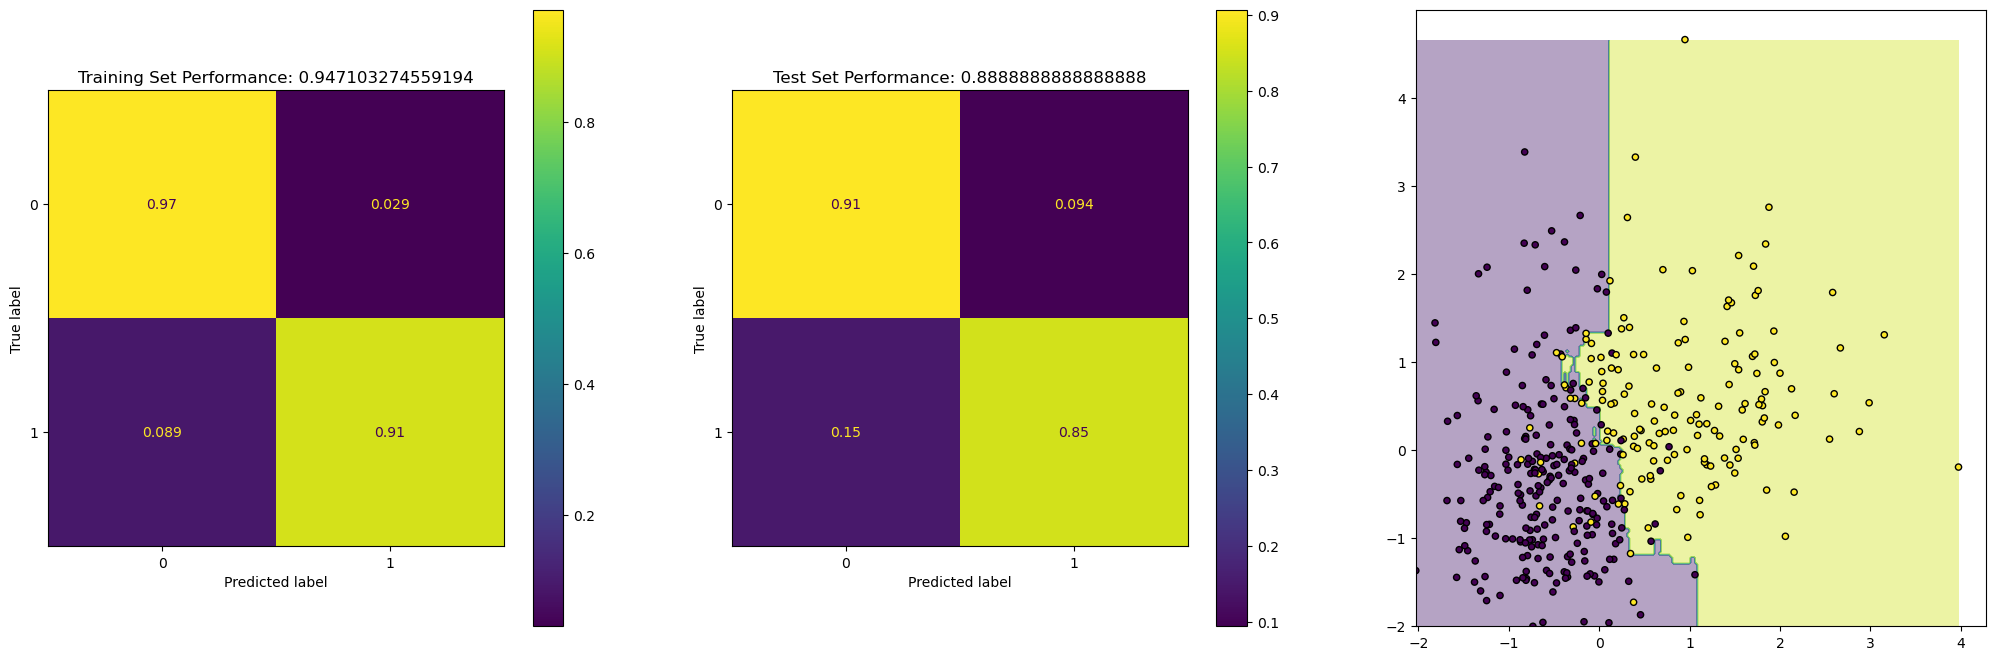

In [22]:
print(halving_search.cv_results_['params'][-1])
rf = RandomForestClassifier(random_state=42).set_params(**halving_search.cv_results_['params'][-1])
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

## Final Thoughts
In this example we've:
* Explored how to perform classification using three different methods: SVMs, K-Nearest Neighbours Classifiers (cknn), and Random Forests
* SVMs fit a plane to separate our two classes. This requires data to be "linearly separable", which may not always be the case. Kernel functions are our friend in such situations
* SVMs can have the costs of errors altered to better deal with imbalance data
* CKNN is a very simple classifier that simply looks at what class similar points (i.e. neighbouring poinst) are, and classifies the target point according to this. This can work very well, but does require some consideration be given to parameters such as the number of neighbours to consider, and what sort of measure we need to use to compare the measures.
* Random Forests train an ensemble of decision trees, each trained on a subset of the data. When classifying a sample, the results from each tree are combined to determine the overall result. This can help with issues such as overfitting

Note that within this example we've only used a training and testing set for simplicity, and ideally we'd use training, validation and testing sets. Note also that our data was rather simple and even using only two of the dimensions in the data, we've got very good results.